*Ensemble Modeling with Skewed Datasets*
==================================

Here's a quick tutorial about how to use ensemble techniques with undersampling to get good results on an imbalanced data set. I'm going to stick with a very basic model (Adaboost with 100 Decision Tree Stumps) and just work on improving the model by changing the amount of training data I feed the model. The point of this kernel isn't to adjust the hyperparameters to find the best model, it's just to demonstrate how powerful ensembling can be on a skewed dataset.

_________________________
We'll look at three cases:
1. Adaboost model with no undersampling.
2. Adaboost model with undersampling.
3. Ensembled model with undersampling.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import calibration_curve

In [43]:
def load_fraud_data(filename):
    df_data = pd.read_csv(filename)
    return df_data

df_data = load_fraud_data('C:/Users/E154709/Desktop/Mohawk/Claims/Data/modelData2.csv')

In [44]:
print(df_data.head(2))

   Unnamed: 0  PRIMARY_CUSTOMER_GK  Claims  numClaims  INVENTORY_STYLE_CD  \
0           0                55116       1          2                1228   
1           1                55121       1          2                1780   

   INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  INVENTORY_COLOR_CD  dollarClaims  \
0                 73                    84                1873   8098.559570   
1                 34                    78                 681   4675.669922   

   numSales  dollarSales    CUSTOMER_NAME  dollarPerClaim  dollarPerSale  \
0      10.0    241296.53  CB FLOORING LLC     4049.279785      24129.653   
1      10.0    112419.43  CB FLOORING LLC     2337.834961      11241.943   

   claimRatio  
0    0.033563  
1    0.041591  


So let's start with the normal setup of our X and y data. Don't worry about the 'Class' column being kept in X_data, I'll pass through the slice X_data[ls_features] when I fit my classifier later on. We'll also add a confusion matrix plotting function to visualize our model performance. 

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def _replace_inf(X):
    # replace inf and na
    X_inf = X.replace(np.inf, np.nan)
   # X_na =X_inf.dropna(axis=1, how="all")    
    X = X_inf.fillna(method='ffill')
    X = X.fillna(method='pad')
    return X

def _read_inputTags():
    # read input tags
    inputTags = ['numClaims',
               'numSales',
               'dollarPerClaim',
               'dollarPerSale',
               'claimRatio',
               'INVENTORY_STYLE_CD',
               'INVENTORY_SIZE_CD',
               'INVENTORY_BACKING_CD',
               'INVENTORY_COLOR_CD'
              ]
    return inputTags

def classification_setup(df_data):
    '''Returns X_data, y_data, ls_features'''
    inputTags = _read_inputTags()
    yTags = 'Claims'
    modelData_inf = _replace_inf(df_data)
    X_data = modelData_inf[inputTags]
    y_data = modelData_inf[yTags]
    y_data = pd.DataFrame(y_data)

    #X_data, y_data = df_data, df_data['Claims']
    ls_features = list(X_data.keys())
    #class_index = ls_features.index('Class')
    #ls_features.pop(class_index)
    return X_data, y_data, ls_features

X_data, y_data, ls_features = classification_setup(df_data)

In [46]:
print(df_data.head(2), y_data.head(2))
print(ls_features)

   Unnamed: 0  PRIMARY_CUSTOMER_GK  Claims  numClaims  INVENTORY_STYLE_CD  \
0           0                55116       1          2                1228   
1           1                55121       1          2                1780   

   INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  INVENTORY_COLOR_CD  dollarClaims  \
0                 73                    84                1873   8098.559570   
1                 34                    78                 681   4675.669922   

   numSales  dollarSales    CUSTOMER_NAME  dollarPerClaim  dollarPerSale  \
0      10.0    241296.53  CB FLOORING LLC     4049.279785      24129.653   
1      10.0    112419.43  CB FLOORING LLC     2337.834961      11241.943   

   claimRatio  
0    0.033563  
1    0.041591      Claims
0       1
1       1
['numClaims', 'numSales', 'dollarPerClaim', 'dollarPerSale', 'claimRatio', 'INVENTORY_STYLE_CD', 'INVENTORY_SIZE_CD', 'INVENTORY_BACKING_CD', 'INVENTORY_COLOR_CD']


**1. Adaboost model with no undersampling.**
---------
Now we're ready to try our first approach.

C:\anaconda35\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix, without normalization
[[ 523 1888]
 [ 281 5540]]


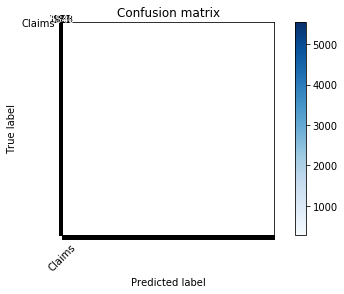

In [27]:
def adaboost_no_undersample(X_data, y_data, ls_features):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)
    dt_clf = DecisionTreeClassifier(max_depth = 3)
    ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                  learning_rate = 0.1, 
                                  n_estimators = 100)
    ada_real.fit(X_train[ls_features], y_train)
    y_pred = ada_real.predict(X_test[ls_features])
    test_conf = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(test_conf, y_data)

adaboost_no_undersample(X_data, y_data, ls_features)

Not the worst, but it doesn't look too great. Though technically the "accuracy" of the model is >99%. There's a high amount of false negatives (bottom left), which are the most crucial mistakes for a fraud problem. The only plus is the model seems to have very little false positives (this trend won't continue.)

**2. Adaboost model with undersampling.**
---------
So let's try undersampling. We'll drastically reduce the size of the train and test set so that the proportions of fraud and non-fraud cases are equal. We'll also create 10 folds, to eyeball if there's any significant variance in our model on this limited data.

In [51]:
def under_sample_kfold(X_data, y_data, n_folds = 10):
    '''Returns list of 10 (default) folds of
    X_train, X_test, y_train, y_test data'''
    #print(X_data.head(2))
    pos_events = X_data[X_data['Claims'] == 1]
    neg_events = X_data[X_data['Claims'] == 0]
    
    #Randomize and pick same n number of events
    number_pos_events = len(pos_events)  
    undersampled_folds = []

    for fold in range(0, n_folds):
        pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
        neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
        undersampled_events = pd.concat([neg_events.head(number_pos_events), pos_events])
        X_data_u, y_data_u = undersampled_events, undersampled_events['Claims']
        X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_data_u, y_data_u, test_size=0.3)
        X_train_u = pd.DataFrame(X_train_u)
        X_test_u = pd.DataFrame(X_test_u)
        undersampled_folds.append([X_train_u, X_test_u, y_train_u, y_test_u])
    return undersampled_folds


folds = under_sample_kfold(df_data, y_data)

The following function can be run with the test set derived from the "balanced" undersampled test set, or from a test set that includes all of the data minus the train data. 

In [49]:
def adaboost_undersample(folds, full_test_set = False):
    
    for fold in folds:
        X_train, X_test, y_train, y_test = fold[0], fold[1], fold[2], fold[3]
            
        dt_clf = DecisionTreeClassifier(max_depth = 3)
        ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100)
        print(X_test.head(2))
        ada_real.fit(X_train[ls_features], y_train)

        if full_test_set == False:
            y_pred = ada_real.predict(X_test[ls_features])
            test_conf = confusion_matrix(y_test, y_pred)
            print (test_conf)
    
        else:
            X_train_and_test = pd.concat([X_train, df_data])
            X_test_full = (X_train_and_test.reset_index()
                                           .drop_duplicates(subset= 'index', keep= False)
                                           .set_index('index'))
            y_test_full = X_test_full['Claims']
        
            #Eval
            y_pred = ada_real.predict(X_test_full[ls_features])
            test_conf = confusion_matrix(y_test_full, y_pred)
            print (test_conf)

2a. Undersampling with undersampled test set.
----------------------------------------------------------
Let's run this first with just the undersampled test set.

In [50]:
adaboost_undersample(folds)

       Unnamed: 0  PRIMARY_CUSTOMER_GK  Claims  numClaims  INVENTORY_STYLE_CD  \
23429       26834               298490       1          1                 451   
30170       33688               336270       1          1                 345   

       INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  INVENTORY_COLOR_CD  \
23429                 34                    32                1537   
30170                 34                     4                1060   

       dollarClaims  numSales  dollarSales                  CUSTOMER_NAME  \
23429   1023.400024       9.0     22909.14    SWAN'S FURN OF N PLATTE INC   
30170    193.830002      10.0     15082.04  GENESEE STREET INDUSTRIES INC   

       dollarPerClaim  dollarPerSale  claimRatio  
23429     1023.400024       2545.460    0.044672  
30170      193.830002       1508.204    0.012852  
[[ 571 2289]
 [ 317 6701]]
       Unnamed: 0  PRIMARY_CUSTOMER_GK  Claims  numClaims  INVENTORY_STYLE_CD  \
25946       29411               315697       1      

[[ 535 2303]
 [ 318 6722]]


These initially look really good! But remember our test sets are 50/50 Fraud/Normal Transactions. A quick glance looks like our Class 1 (Fraud) accuracy went from ~66% to ~85% on our test set with very small False Positive Rate. However, this is a much different test set from what we will be encountering. Which brings us to....

2b. Undersampling with full test set.
----------------------------------------------------------
Let's run this now with a real test set, which thankfully has a much smaller fraud rate (~0.17%) than our balanced undersampled data.

In [52]:
adaboost_undersample(folds, full_test_set = True)

      Unnamed: 0  PRIMARY_CUSTOMER_GK  Claims  numClaims  INVENTORY_STYLE_CD  \
5160        6226               234108       0          1                 818   
6126        7194               235701       1          1                 619   

      INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  INVENTORY_COLOR_CD  \
5160                 34                    31                1441   
6126                 34                    32                 977   

      dollarClaims  numSales  dollarSales               CUSTOMER_NAME  \
5160   1332.849976      10.0     50463.77    WHOLESALE CPT-FOX VALLEY   
6126    450.329987      10.0   4031070.54  SOVEREIGN DISTRIBUTORS INC   

      dollarPerClaim  dollarPerSale  claimRatio  
5160     1332.849976       5046.377    0.026412  
6126      450.329987     403107.054    0.000112  
[[ 580 2185]
 [ 393 6720]]
       Unnamed: 0  PRIMARY_CUSTOMER_GK  Claims  numClaims  INVENTORY_STYLE_CD  \
25931       29396               315537       1          1                

[[ 529 2365]
 [ 306 6678]]


So what we see above is testing each fold's model on every data point that isn't included in the train set gives drastically different results. Now we have a problem where there's thousands of false positive flags. What's happening is adaboost is coming up with a great decision boundary for that area of the feature space. But we have a pretty vast 30 dimensional feature space to predict on.

Let's try to lower that using...

3. Ensembled model with undersampling.
----------------------------------------------------
First before we start making an ensemble, we need to create a CV set. If we ensembled all of our models currently, we would have no Class 1 instances left (all of them are used once or likely multiple times in the 10 training sets). 

In [55]:
def cv_setup(X_data, y_data):
    '''Returns X_data, y_data, X_cv, y_cv, ls_features
    X_cv, y_cv are randomized 10% of data with same class
    proportions'''
    
    
    pos_events = X_data[X_data['Claims'] == 1]
    neg_events = X_data[X_data['Claims'] == 0]
    number_pos_events, number_neg_events, number_events = (len(pos_events), 
                                                           len(neg_events),
                                                           len(X_data))
    pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
    neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
    X_cv = pd.concat([neg_events.tail(number_neg_events//10), 
                      pos_events.tail(number_pos_events//10)])
    y_cv = X_cv['Claims']

    #Get rid of duplicates between CV and Test/Train bank of data
    X_data = pd.concat([X_cv, X_data])
    X_data = (X_data.reset_index()
                    .drop_duplicates(subset= 'index', keep= False)
                    .set_index('index'))
    y_data = X_data['Claims']
    
    return X_data, y_data, X_cv, y_cv, ls_features

In [56]:
#Remake our folds without including 10% of the data for a CV set
X_data, y_data, X_cv, y_cv, ls_features = cv_setup(df_data, y_data)
folds = under_sample_kfold(X_data, y_data)

So let's see the results of an ensemble of 10 models (one derived from each fold of the data) tested on just the CV set.

In [57]:
def adaboost_undersample_ensemble(folds):
    
    X_train_all_folds = pd.DataFrame()
    ada_ensemble = []
    
    for fold in folds:
        X_train, X_test, y_train, y_test = fold[0], fold[1], fold[2], fold[3]
    
        dt_clf = DecisionTreeClassifier(max_depth = 1)
        ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100)
        ada_real.fit(X_train[ls_features], y_train)
        #Concatenate all train sets and store each fold models
        X_train_all_folds = pd.concat([X_train_all_folds, X_train])
        ada_ensemble.append(ada_real)
    
    #Call scorer
    ensemble_score(X_cv, y_cv, ada_ensemble)

def ensemble_score(X_test, y_test, models, cutoff = 0.5, e_cutoff = 5):
    '''Prints confusion matrix for an ensemble of models based on 
    probability cutoff (cutoff) of each model and voting cutoff 
    (e_cutoff) for an ensemble vote. Default is >50% probability
    and > 5 votes out of 10'''
    
    for fold in range(0, len(models)):
        X_test.loc[:, ('Prob fold ' + str(fold))] = models[fold].predict_proba(X_test[ls_features])[:,1]
        X_test.loc[:, ('ADAPred fold ' + str(fold))] = (X_test[('Prob fold ' + str(fold))] >= cutoff).astype(int)
    
    X_test.loc[:, 'Ensemble Score'] = X_test[['ADAPred fold ' + str(i) for i in range(0, len(models))]].sum(axis = 1)
    X_test.loc[:, 'Ensemble Pred'] = (X_test['Ensemble Score'] > e_cutoff).astype(int)

    ensemble_conf = confusion_matrix(y_test, X_test[('Ensemble Pred')])
    print (ensemble_conf)

adaboost_undersample_ensemble(folds)

[[  87  863]
 [  44 2297]]


Everything looks pretty good! The amount of false positives has dropped significantly, and we haven't sacrificed the sensitivity (true positive rate) of our model at all. 

Ensemble Validation
================
Let's try some ensemble validation before we go with this ensemble technique.

Validation on our ensemble technique is a bit tricky - we can change our ensemble parameters (probability cutoff, ensemble vote cutoff) but we can potentially overfit this technique to our CV set. To avoid this, we should reshuffle the data, redraw our CV set, retrain our kfold models, and retry our ensemble technique on the CV set.

In [59]:
X_data, y_data, ls_features = classification_setup(df_data)
X_data, y_data, X_cv, y_cv, ls_features = cv_setup(df_data, y_data)
folds = under_sample_kfold(X_data, y_data)
adaboost_undersample_ensemble(folds)

[[ 102  848]
 [  49 2292]]


Similar results! Again, this was meant to be an introduction to ensemble learning, a powerful technique for skewed data sets. Some key things to keep in mind:

1. When undersampling to train a model, make sure to validate it with a real test set, not an "undersampled" test set.
2. When developing an ensemble technique, use a CV set. It's very likely you'll run out of the minority class when you use slices of the data to create several unique models, even if the data for each model is chosen at random.
3. Be sure to validate your ensemble technique by reshuffling your data and redrawing a new CV set.

